### Hierarchical Principal Components Analysis

계층적 PCA(Hierarchical PCA)는 대규모 또는 복잡한 데이터 세트를 효과적으로 분석하기 위한 방법이다. 이 접근법은 데이터를 여러 서브셋으로 분할한 후 각 서브셋에 대해 주성분 분석(PCA)을 별도로 수행한다

Subset별로 PCA를 통해 각 서브셋의 주요 패턴과 구조를 추출하며, 이후 이러한 결과를 종합하여 전체 데이터 세트의 특성을 파악한다. 계층적 PCA는 대규모 데이터 세트를 다루는 데 있어 계산상의 부담을 줄이고, 서브셋 간의 다양한 관계나 특성을 더 깊이 이해할 수 있다는 것이 장점이다 이 방법은 복잡한 구조를 가진 데이터 세트를 세분화하여 분석하는 데 특히 유용하며, 금융 분야에서 주로 쓰이고 있다. 그러나 계층적 PCA는 전체 데이터에 대한 일반적인 PCA와 다른 결과를 줄 가능성이 크기 때문에, 분석 결과 해석 시 데이터 분할 방식과 Subset의 특성을 모두 고려해야 한다

계층적 PCA에는 다음과 같은 단계로 이뤄진다

1. 트리 군집화
2. 준 대각화(Quasi-Diagonalization)
3. 재귀적 이분법

이번절에서는 계층적 군집화를 통해 금융 시계열에서 자산의 배분이 어떻게 이루어지는지 보도록 한다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import risk_models, expected_returns, BlackLittermanModel, EfficientFrontier
import yfinance as yf
import warnings 
warnings.filterwarnings("ignore")

TICKERS = ['AAPL','GOOGL','XOM','WMT','V','NVDA','JPM','F']
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS, 
    start = START_DATE, 
    end = END_DATE,
    progress = False,
    interval = '1d'
)['Close']
ret = data.pct_change().dropna()

#### 1. 트리 군집화

관측값 $X$의 $T \times N$행렬을 고려해 보자. 행렬은 $T$기간에 대한 $N$개 변수 계열이다. 이 $N$ 열벡터를 군집의 계층 구조로 병합해 배분을 트리 그래프를 따라 하향식으로 흘러내리고자 한다

첫째, 원소가 $\rho = \{\rho_{i,j}\}_{i,j = 1, \dots, N}$인 $N \times N$ 상관관계 행렬을 계산한다. 여기서 $\rho_{i,j} = \rho [X_i, X_j]$다. 거리 척도는 $d : (X_i, X_j) \subset B \rightarrow \mathbb{R} \in [0,1], d_{i,j} = d[X_i, X_j] = \sqrt{\frac{1}{2}(1 - \rho_{i,j})}$로 정의되며, 여기서 $B = [1,\dots, i, \dots, N]$내의 원소의 카티시안 곱이다. 이는 $N \times N$ 거리 행렬 $D = \{d_{i,j}\}_{i,j = 1, \dots, N}$을 계산할 수 있게 해준다. 행렬 $D$는 다음과 같은 성질을 갖는다

$$d[x, y] \geq 0$$
$$d[x,y] = 0 \Leftrightarrow X = Y$$
$$d[x,y] = d[Y,X]$$
$$d[X,Z] \geq d[x,y] + d[Y,Z]$$

따라서, 행렬 $D$는 적절한 거리 공간이라고 할 수 있다

In [2]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform

cov, corr = data.cov(), data.corr()
dist = np.sqrt((1 - corr) / 2) # distance matrix
link = sch.linkage(squareform(dist), method = 'single') # linkage matrix

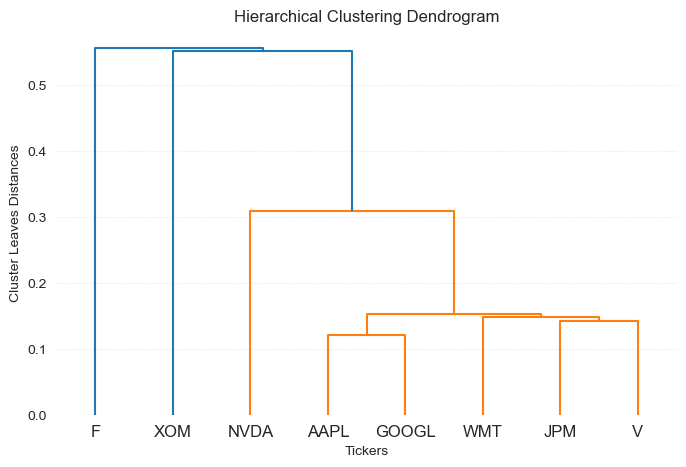

In [3]:
columns = data.columns
fig, ax = plt.subplots(figsize = (8, 5))
dendrogram(link, labels = columns, ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Tickers')
plt.ylabel('Cluster Leaves Distances')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

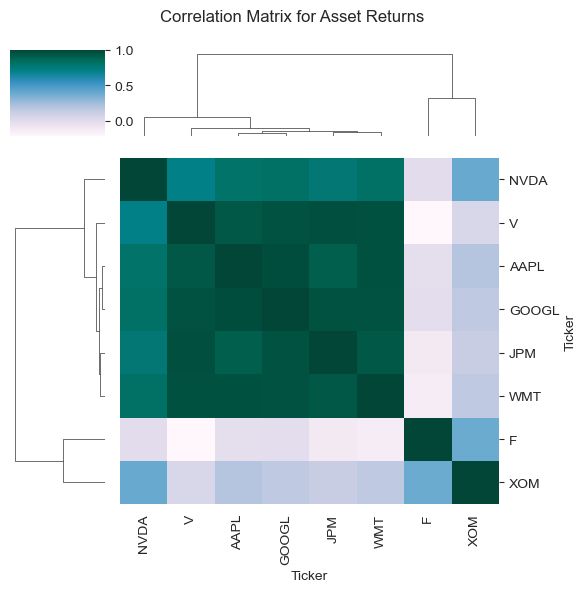

In [4]:
g = sns.clustermap(corr, figsize = (6, 6), cmap = 'PuBuGn')
g.fig.suptitle('Correlation Matrix for Asset Returns')
plt.tight_layout()
plt.show()

#### 2. 준 대각화

이 단계는 공분산 행렬의 행과 열을 재구성해 가장 큰 값이 대각선에 위치하게 한다. 공분산의 준대각화는 유용한 속성이다. 유사한 금융 상품은 함께 배치되고 다른 상품은 서로 떨어뜨리도록 배치한다. 알고리즘은 아래의 코드와 같이 작동하는데, 연결 행렬의 각 행이 두 branch를 하나로 합친다는 것을 알고 있다. 가지 내의 군집들을 그 구성 성분으로 재귀적으로 교체하여, 군집이 더이상 남지 않을 때까지 반복한다. 이런 교체는 군집화의 순서를 유지하게 하는데, 출력은 군집화되지 않은 원소의 정렬된 리스트이다. 아래의 예제를 통해 준 대각화에 대해서 간단히 살펴보자.

In [5]:
def QuasiDiag(link: np.ndarray) -> list:
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]    # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)    # make space
        df0 = sortIx[sortIx >= numItems]    # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]    # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sortIx = pd.concat([sortIx, df0])    # item 2
        sortIx = sortIx.sort_index()    # re-sort
        sortIx.index = range(sortIx.shape[0])    # re-index
    lst =  sortIx.tolist()
    return lst

In [6]:
print(QuasiDiag(link)) # 준 대각화된 성분의 index

[1, 7, 4, 0, 2, 6, 3, 5]


#### 3. 재귀적 이분법

2를 통해 준대각 행렬을 얻었다. 역분산 배분은 대각 공분산 행렬에 대해 최적이다. 이 사실들로부터 두 가지 활용이 가능하다

1. 상향식 : 연속된 부분 집합의 분산을 역분산 배분의 분산으로 정의한다
2. 하향식 : 인접한 부분 집합 간의 배분을 이들의 총 분산에 역으로 비례하도록 분할한다. 아래의 알고리즘은 하향식 아이디어를 공식화한다

다음 알고리즘은 하향식 아이디어를 공식화한다.

1. 알고리즘은 다음과 같이 초기화된다.
    - 원소 리스트를 설정한다. 즉 $L = \{L_0\}, L_0 = \{n\}_{n = 1, \dots, N}$
    - 모든 원소에 단위 비중을 배분한다. 즉 $w_n = 1, \forall n = 1, \dots, N$
2. $\forall L_i \in L$에 대해서 $\vert L_i \vert = 1$이면 중단
3. $\vert L_i \vert > 1$인 각 $\vert L_i \vert \in L$에 대해
    - $L_i$를 두 부분 집합으로 이분한다. 즉 $L_i^{(1)} \cup L_i^{(2)} = L_i$, 여기서 $\vert L_i^{(1)} \vert = \text{int}\left[ \frac{1}{2} \vert L_i\vert \right]$이고, 순서는 유지된다.
    - $L_i^{(j)}, j = 1, 2$의 분산을 이차 형식 $\tilde{V}_i^{(j)} \equiv \tilde{w}_i^{(j)^\prime} V_i^{(j)} \tilde{w}_i^{(j)}$로 정의한다. 여기서 $V_i^{(j)}$은 $L_i^{(j)}$ 이분 구성 요소 간의 공분산 행렬이고, $\tilde{w}_i^{(j)} = \text{diag} \left[ V_i^{(j)}\right]^{-1} \frac{1}{\text{tr} \left[ \text{diag}\left[ V_i^{(j)}\right]^{-1}\right]}$이고 여기서 $\text{diag}[\cdot]$와 $\text{tr}[\cdot]$은 각각 대각과 대각합 연산자다.
    - 분할 인수 계산 : $\alpha_i = 1 - \frac{\tilde{V}_i^{(1)}}{\tilde{V}_i^{(1)} + V_i^{(2)}}$이므로 $0 \leq \alpha_i \leq 1$이다.
    - $\forall n \sin L_i^{(1)}, \alpha_i$ 인수로 배분 $w_n$의 크기 재조정
    - $\forall n \in L_i^{(2)}, (1 - \alpha_i)$인수로 배분 $w_n$의 크기 재조정
4. 단계 2로 돌아가서 앞의 단계를 반복

단계 3b는 분할 $L_i^{(j)}$의 분산을 역분산 비중 $\tilde{w}_i^{(j)}$를 사용해 정의하므로 준 대각화를 상향식으로 활용한다. 단계 3c는 군집의 분산에 역비례해 비중을 분할하므로 준대각화를 하향식으로 활용한다. 이 알고리즘은 각 반복 시행마다 상단의 계층 수준으로부터 받은 비중을 분할하므로 $0 \leq w_i \leq 1, \forall i = 1, \dots, N$과 $\sum_{i=1}^N w_i = 1$을 보장한다. 이 단계에서는 단계 3c, 3d, 3e의  식을 사용자 기호에 맞게 바꿈으로써 제약 조건을 쉽게 도입할 수 있다. 아래 코드는 위 단계를 구현한 것이다.

In [7]:
def InversePortfolio(cov, **kargs) : 
    ivp = 1 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ClusterVar(cov, cItems) :
    cov_ = pd.DataFrame(cov).loc[cItems, cItems] # 행렬 분할
    w_ = InversePortfolio(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

def RecBipart(cov: np.ndarray, sortIx: list) -> pd.Series:
    w = pd.Series([1] * len(sortIx), index=sortIx)
    cItems = [sortIx]    # 모든 아이템을 하나의 군집으로 초기화
    while len(cItems) > 0:
        cItems = [i[int(j): int(k)] for i in cItems
                  for j, k in ((0, len(i) / 2), (len(i) / 2, len(i))) if len(i) > 1]    # bi-section
        for i in range(0, len(cItems), 2):    # parse in pairs
            cItems0 = cItems[i]    # cluster 1
            cItems1 = cItems[i+1]    # cluster 2
            cVar0 = ClusterVar(cov, cItems0)
            cVar1 = ClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha    # weight 1
            w[cItems1] *= 1 - alpha    # weight 2
    return w

In [8]:
Ix = QuasiDiag(link)
weights = RecBipart(ret.cov().values, Ix)
weights = pd.Series(
    weights.values,
    index = ret.iloc[:, weights.index].columns,
    name = 'weights'
)

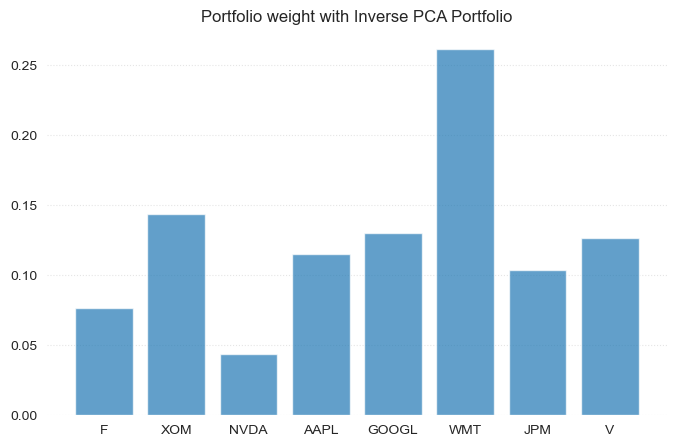

In [9]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.bar(
    ret.loc[:, weights.index].columns, 
    weights, 
    alpha = 0.7
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title("Portfolio weight with Inverse PCA Portfolio")
plt.show()

### Montecarlo Simulation

아래의 코드는 HRP, CLA, IVP의 세 가지 배분 기법에 대한 몬테카를로 실험을 구현한다. 모든 라이브러리는 HRP를 제외하고는 표준이다. subRoutine `generateData`는 상관된 데이터를 두 형태의 랜덤 충격으로 시뮬레이션하는데 하나의 충격은 다양한 상품에 공통적으로 영향을 미치지만, 다른 하나는 단일 상품에만 특정적으로 영향을 미친다. 각 형태 별로 두 종류의 충격이 있는데 하나는 음, 하나는 양이다. 실험의 변수는 `hrpMC` 함수의 인수로 설정된다. 이들은 임의로 선택되고, 사용자는 다른 조합으로 실험해 볼 수도 있다.

In [33]:
import scipy.cluster.hierarchy as sch
import random
from tqdm import tqdm

class CLA:
    def __init__(self, mean, covar, lB, uB):
        # Initialize the class
        if np.all(mean == np.ones(mean.shape) * mean.mean()):
            mean[-1, 0] += 1e-5
        self.mean = mean
        self.covar = covar
        self.lB = lB
        self.uB = uB
        self.w = []  # solution
        self.l = []  # lambdas
        self.g = []  # gammas
        self.f = []  # free weights
        
    def solve(self):
        # Compute the turning points, free sets, and weights
        f, w = self.initAlgo()
        self.w.append(np.copy(w))  # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        
        while True:
            l_in, i_in, bi_in = None, None, None
            # Case a): Bound one free weight
            if len(f) > 1:
                covarF, covarFB, meanF, wB = self.getMatrices(f)
                covarF_inv = np.linalg.inv(covarF)
                j = 0
                for i in f:
                    l, bi = self.computeLambda(covarF_inv, covarFB, meanF, wB, j, [self.lB[i], self.uB[i]])
                    if l is not None and (l_in is None or l > l_in):
                        l_in, i_in, bi_in = l, i, bi
                    j += 1

            # Case b): Free one bounded weight
            l_out, i_out = None, None
            if len(f) < self.mean.shape[0]:
                b = self.getB(f)
                for i in b:
                    f_plus_i = f + [i]
                    covarF, covarFB, meanF, wB = self.getMatrices(f_plus_i)
                    covarF_inv = np.linalg.inv(covarF)
                    l, bi = self.computeLambda(covarF_inv, covarFB, meanF, wB, len(meanF) - 1, self.w[-1][i])
                    if (l is not None) and (self.l[-1] is None or l < self.l[-1]) and (l_out is None or l > l_out):
                        l_out, i_out = l, i
            
            if (l_in is None or l_in < 0) and (l_out is None or l_out < 0):
                # Compute minimum variance solution
                self.l.append(0)
                covarF, covarFB, meanF, wB = self.getMatrices(f)
                covarF_inv = np.linalg.inv(covarF)
                meanF = np.zeros(meanF.shape)
            else:
                # Decide lambda
                if l_in is not None and (l_out is None or l_in > l_out):
                    self.l.append(l_in)
                    f.remove(i_in)
                    w[i_in] = bi_in  # set value at the correct boundary
                else:
                    self.l.append(l_out)
                    f.append(i_out)
                
                covarF, covarFB, meanF, wB = self.getMatrices(f)
                covarF_inv = np.linalg.inv(covarF)

            # Compute solution vector
            wF, g = self.computeW(covarF_inv, covarFB, meanF, wB)
            for i in range(len(f)):
                w[f[i]] = wF[i]
            self.w.append(np.copy(w))  # store solution
            self.g.append(g)
            self.f.append(f[:])
            if self.l[-1] == 0:
                break

        # Purge turning points
        self.purgeNumErr(1e-10)
        self.purgeExcess()
        
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a = np.zeros((self.mean.shape[0]), dtype=[('id', int), ('mu', float)])
        b = [self.mean[i][0] for i in range(self.mean.shape[0])]  # dump array into list
        a[:] = list(zip(range(self.mean.shape[0]), b))  # fill structured array with list conversion
        #2) Sort structured array
        b = np.sort(a, order='mu')
        #3) First free weight
        i, w = b.shape[0], np.copy(self.lB)
    
        while sum(w) < 1:
            i -= 1
            w[b[i]['id']] = self.uB[b[i]['id']]
    
        w[b[i]['id']] += 1 - sum(w)
        return [b[i]['id']], w
    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1][0]
        if c<0:
            bi=bi[0][0]
        return bi
    
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
    
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
    
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF = self.reduceMatrix(self.covar,f,f)
        meanF = self.reduceMatrix(self.mean,f,[0])
        b = self.getB(f)
        covarFB = self.reduceMatrix(self.covar,f,b)
        wB = self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
    
    def reduceMatrix(self,matrix,listX,listY):
        # Reduce a matrix to the provided list of rows and columns
        if len(listX) == 0 or len(listY) == 0:return
        matrix_ = matrix[:,listY[0]:listY[0]+1]
        
        for i in listY[1:]:
            a = matrix[:,i:i+1]
            matrix_ = np.append(matrix_,a,1)
            
        matrix__ = matrix_[listX[0]:listX[0]+1,:]
        
        for i in listX[1:]:
            a = matrix_[i:i+1,:]
            matrix__ = np.append(matrix__,a,0)
        return matrix__
    
    def purgeNumErr(self, tol):
        # Purge violations of inequality constraints (associated with ill-conditioned covar matrix)
        i = 0
        while i < len(self.w):
            w = self.w[i]
            remove = False
            for j in range(w.shape[0]):
                if w[j] - self.lB[j] < -tol or w[j] - self.uB[j] > tol:
                    remove = True
                    break
            if remove:
                del self.w[i]
                del self.l[i]
                del self.g[i]
                del self.f[i]
            else:
                i += 1
                
    def purgeExcess(self):
        # Remove violations of the convex hull
        i,repeat=0,False
        while True:
            if repeat==False:i+=1
            if i==len(self.w)-1:break
            w=self.w[i]
            mu=np.dot(w.T,self.mean)[0,0]
            j,repeat=i+1,False
            while True:
                if j==len(self.w):break
                w=self.w[j]
                mu_=np.dot(w.T,self.mean)[0,0]
                if mu<mu_:
                    del self.w[i]
                    del self.l[i]
                    del self.g[i]
                    del self.f[i]
                    repeat=True
                    break
                else:
                    j+=1
    
    def computeLambda(self, covarF_inv, covarFB, meanF, wB, i, bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return None,None
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if wB is None or wB.size == 0:
            # All free assets or empty array
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
        
    def computeW(self, covarF_inv, covarFB, meanF, wB):
        #1) compute gamma
        onesF = np.ones(meanF.shape)
        g1 = np.dot(np.dot(onesF.T, covarF_inv), meanF)
        g2 = np.dot(np.dot(onesF.T, covarF_inv), onesF)
        if wB is None or wB.size == 0:
            g = float(-self.l[-1] * g1 / g2 + 1 / g2)
            w1 = 0
        else:
            onesB = np.ones(wB.shape)
            g3 = np.dot(onesB.T, wB)
            g4 = np.dot(covarF_inv, covarFB)
            w1 = np.dot(g4, wB)
            g4 = np.dot(onesF.T, w1)
            g = float(-self.l[-1] * g1 / g2 + (1 - g3 + g4) / g2)
        #2) compute weights
        w2 = np.dot(covarF_inv, onesF)
        w3 = np.dot(covarF_inv, meanF)
        return -w1 + g * w2 + self.l[-1] * w3, g

    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
    
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
    
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
    
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
    
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
        
def corrDist(corr) :
    dist = ((1 - corr) / 2) ** 0.5
    return dist

def generateData(nObs, sLength, size0, size1, mu0, sigma0, sigma1F) :
    # Time seires of correlated variable
    # 1) generate uncorrelated random variables 
    x = np.random.normal(mu0, sigma0, size = (nObs, size0))
    # 2) create correlation between the variables 
    cols = [random.randint(0, size0-1) for i in range(size1)]
    y = x[:,cols] + np.random.normal(0,sigma0*sigma1F,size=(nObs,len(cols))) 
    x = np.append(x,y,axis=1)
    #3) add common random shock
    point = np.random.randint(sLength, nObs-1, size = 2) 
    x[np.ix_(point,[cols[0],size0])]=np.array([[-.5,-.5],[2,2]]) 
    #4) add specific random shock 
    point=np.random.randint(sLength, nObs-1, size = 2) 
    x[point,cols[-1]] = np.array([-.5,2])
    return x,cols

def getHRP(cov,corr):
    # Construct a hierarchical portfolio
    corr,cov = pd.DataFrame(corr),pd.DataFrame(cov) 
    dist = corrDist(corr) 
    link = sch.linkage(dist,'single') 
    sortIx = QuasiDiag(link) 
    sortIx = corr.index[sortIx].tolist() # recover labels
    hrp = RecBipart(cov,sortIx)
    
    return hrp.sort_index()

def getCLA(cov, **kargs):
    # Compute CLA's minimum variance portfolio 
    mean = np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf 
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

def hrp_monte_carlo(
        numIters=1000, nObs=520, size0=5, size1=5, mu0=0, 
        sigma0=0.01, sigma1F=0.25, sLength=260, rebal=22
    ) -> pd.DataFrame :
    methods = [InversePortfolio, getHRP, getCLA]
    stats = {func.__name__: pd.Series(dtype=float) for func in methods}
    pointers = range(sLength, nObs, rebal)

    for numIter in tqdm(range(int(numIters))):
        x, cols = generateData(nObs, sLength, size0, size1, mu0, sigma0, sigma1F)
        results = {func.__name__: pd.Series(dtype=float) for func in methods}

        for pointer in pointers:
            x_in = x[pointer-sLength:pointer]
            cov_, corr_ = np.cov(x_in, rowvar=False), np.corrcoef(x_in, rowvar=False)
            x_out = x[pointer:pointer+rebal]

            for func in methods:
                weights = func(cov=cov_, corr=corr_)
                returns = pd.Series(np.dot(x_out, weights))
                results[func.__name__] = pd.concat([results[func.__name__], returns], ignore_index=True)

        for func in methods:
            cum_returns = (1 + results[func.__name__]).cumprod()
            stats[func.__name__].at[numIter] = cum_returns.iloc[-1] - 1

    stats_df = pd.DataFrame(stats)
    stats_df.to_csv('stats.csv')
    df_std, df_var = stats_df.std(), stats_df.var()
    comparison = df_var / df_var['getHRP'] - 1
    print(pd.concat([df_std, df_var, comparison], axis=1))
    return stats_df

In [34]:
if __name__=='__main__': hrp_monte_carlo()

100%|██████████| 1000/1000 [04:10<00:00,  4.00it/s]

                         0         1         2
InversePortfolio  0.299721  0.089833  0.320869
getHRP            0.260788  0.068010  0.000000
getCLA            0.338452  0.114550  0.684302
